In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="white")
from pyearth import Earth
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics as metrics
from scipy.stats import entropy
import math
from pyearth import export
from sympy import *
import copy
import matplotlib.transforms as transforms
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, PathPatch, Wedge
from matplotlib.collections import PatchCollection
from IPython.core.pylabtools import figsize

In [2]:
data = pd.read_csv('/home/fotis/dev_projects/spark_test/target/crimeDataCoordinates_normalized_full/part-r-00000-11fd4f3b-2cdb-4ce0-9553-aed4be9bc244.csv', sep=",", header=0)
# data2 = pd.read_csv('/home/fotis/dev_projects/spark_test/target/crime_results_/gau-x__gau-l_varx-0.01_varl-0.0001_mul-0.04/part-00000/part-00000', sep=",", header = None)
data2 = pd.read_csv('/home/fotis/dev_projects/spark_test/target/crime_results_/uni-x__gau-l_varx-0.01_multimodal-l(0.02_0.08_0.1)/part-00000/part-00000', sep=",", header = None)

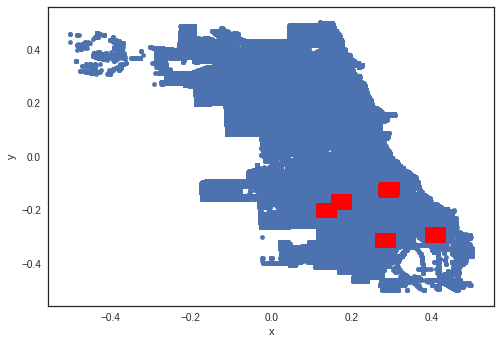

In [3]:
data.columns = ['x','y']
data2.columns = ['x','y','l','cardinality']
data2 = data2[data2['cardinality']>0]
data2 = data2.set_index(np.arange(data2.count()[0]))
fig = plt.figure()
ax = fig.add_subplot(111)
data.plot(kind='scatter', x='x',y='y',ax=ax)
data2.plot(kind='scatter', x='x',y='y', c='r', ax=ax)

In [4]:
min_of_cardinality = data2['cardinality'].min()
max_of_cardinality = data2['cardinality'].max()
xmin = data['x'].min()
xmax = data['x'].max()
ymin = data['y'].min()
ymax = data['y'].max()
lmin = data2['l'].min()
lmax = data2['l'].max()
print("Minimum cardinality : {0}\nMaximum Cardinality : {1}".format(min_of_cardinality, max_of_cardinality))
print("Xmin :{0}\nXmax: {1}".format(xmin, xmax))
print("Ymin : {0}\nYmax : {1}".format(ymin, ymax))
print("Lmin : {0}\nLmax : {1}".format(lmin, lmax))

Minimum cardinality : 6197
Maximum Cardinality : 2831560
Xmin :-0.5
Xmax: 0.5
Ymin : -0.5
Ymax : 0.5
Lmin : 0.0200004543611
Lmax : 0.266533577591


In [5]:
max_tot_data = data.count()[0]
min_tot_data = 0

<h2>Normalizing values</h2></br>
$$X_{norma} = \frac{X - min(X)}{max(X) - min(X)}$$

In [6]:
#Normalize all values to (0,1)
data['x'] = (data['x'] - xmin) / (xmax - xmin)
data['y'] = (data['y'] - ymin) / (ymax - ymin)
#Normalize all values for queries to (0,1)
data2['x'] = (data2['x'] - xmin) / (xmax - xmin)
data2['y'] = (data2['y'] - ymin) / (ymax - ymin)
data2['l'] = (data2['l'] - lmin) / (lmax - lmin)
# data2['cardinality'] = (data2['cardinality'] - min_of_cardinality) / (max_of_cardinality - min_of_cardinality)

/home/fotis/.local/lib/python2.7/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


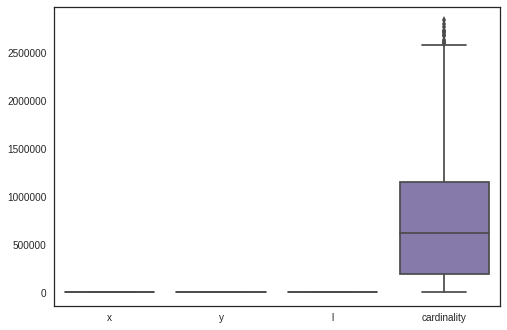

In [7]:
sns.boxplot(data2)

<h2>Pre-Learning Phase 1st Level Clustering $$\mathbf{x}$$</h2></br>
<b>Cluster and train model for sample 0.2 of queries</b>

In [8]:
prelearningdf = data2.sample(frac=.2)
trainingdf = data2.drop(prelearningdf.index)

In [9]:
print("Resulting prelearning set : {0}\nResulting training set : {1}".format(prelearningdf.count()[0], trainingdf.count()[0]))

Resulting prelearning set : 10000
Resulting training set : 40000


<b>Resetting Indexes</b>

In [10]:
prelearningdf = prelearningdf.set_index(np.arange(prelearningdf.count()[0]))
trainingdf = trainingdf.set_index(np.arange(trainingdf.count()[0]))

In [11]:
X = prelearningdf[['x','y']].as_matrix()

16


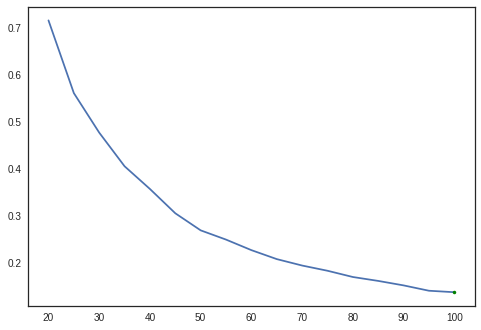

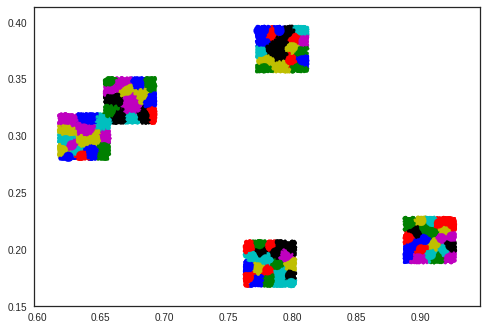

In [12]:
# #Tuning k-parameter for kmeans
avg_vars = []
clusters_ = range(20,150,5)
vigil = 0.008
c=20

init = True
diff = 1
while diff>= vigil:
    kmeans = MiniBatchKMeans(n_clusters=c, max_no_improvement=None)
    kmeans.fit(X)
    avg_vars.append(kmeans.inertia_)
    if not init:
        diff = (avg_vars[-2]-avg_vars[-1])
    else:
        init=False
    c+=5
c-= 5    
avg_vars = np.array(avg_vars)
selected = np.where(avg_vars == np.min(avg_vars))[0][0]
print(selected)
plt.plot(range(20,c+5,5), avg_vars)
plt.plot(c, avg_vars[selected],'.g')
# #End of tuning

CLUSTERS = clusters_[selected]
kmeans = MiniBatchKMeans(n_clusters=CLUSTERS)
kmeans.fit(X)
if hasattr(kmeans, 'labels_'):
    y_pred = kmeans.labels_.astype(np.int)
else:
    y_pred = kmeans.predict(X)

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * CLUSTERS)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(prelearningdf['x'],prelearningdf['y'],color=colors[y_pred].tolist(), s=10)

if hasattr(kmeans, 'cluster_centers_'):
    centers = kmeans.cluster_centers_
    center_colors = colors[:len(centers)]
    plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)

plt.show()

<b>Assigning Queries to clusters</b>

In [13]:
clusters = {}
# fig, axs = plt.subplots(ncols=5, nrows=15,figsize=(30,25))
for i in range(len(kmeans.cluster_centers_)):
    item = np.where(kmeans.labels_== i)
    clusters[i] = prelearningdf.ix[item]
#     sns.regplot(x='l', y='cardinality', data=clusters[i],fit_reg=False, ax=axs[(i/5)][(i%5)])

<b>Checking if cardinality variance is less within cluster than before</b>

<h2>Pre-Learning 2nd Level cluster $$\theta$$</h2>
<b>Cluster theta</b>

<b>Resetting indexes for each cluster because we need to re-cluster</b>

In [14]:
for i in clusters:
    clusters[i] = clusters[i].set_index(np.arange(clusters[i].count()[0]))

<b>Datastructure to hold each subcluster associated with a cluster</b>

<b>For every cluster, use a subclustering algorithm to cluster based on theta</b>

In [15]:
theta_centers = []
subclusters = []
#For each cluster
for j in clusters:
    T = clusters[j]['l'].as_matrix()
    #Tuning k-parameter for kmeans
    T = T.reshape(-1, 1)
#     avg_vars = []
#     vigil = 0.008
#     avg_vars = []
#     c=1
#     # for c in clusters_:
#     #     var = 0
#     #     kmeans = MiniBatchKMeans(n_clusters=c, max_no_improvement=None)
#     #     kmeans.fit(X)
#     #     avg_vars.append(kmeans.inertia_)
#     init = True
#     diff = 1
#     while diff>= vigil:
#         t_kmeans = MiniBatchKMeans(n_clusters=c, max_no_improvement=None)
#         t_kmeans.fit(T)
#         avg_vars.append(t_kmeans.inertia_)
#         if not init:
#             diff = (avg_vars[-2]-avg_vars[-1])
#         else:
#             init=False
#         c+=1
#     c-= 1    

#     avg_vars = np.array(avg_vars)
#     selected = np.where(avg_vars == np.min(avg_vars))[0][0]
#     plt.plot(range(1,c+1,1), avg_vars)
#     plt.plot(c, avg_vars[selected],'.g')
#     #End of tuning

    subcluster = []
    CLUSTERS = 3#selected
    t_kmeans = MiniBatchKMeans(n_clusters=CLUSTERS)
    t_kmeans.fit(T)
    if hasattr(t_kmeans, 'labels_'):
        t_pred = t_kmeans.labels_.astype(np.int)
    else:
        t_pred = kmeans.predict(T)
    theta_centers.append(t_kmeans.cluster_centers_)
    for i in range(CLUSTERS):
            item = np.where(t_kmeans.labels_== i)
            s = clusters[j].ix[item]
            subcluster.append(s)
        
    subclusters.append(subcluster)

<b>Count for every subcluster and resetting indexes</b>

In [16]:
for i in range(len(subclusters)):
    for j in range(len(subclusters[i])):
#         print("Count for subcluster {0}/{1} : {2}".format(i,j,subclusters[i][j].count()[0]))
        #Reset index trainingdf = trainingdf.set_index(np.arange(trainingdf.count()[0]))
        subclusters[i][j] = subclusters[i][j].set_index(np.arange(subclusters[i][j].count()[0])) 

<b>Creating MARS models (one per SUB-cluster)</b>

In [17]:
#Fit an Earth model for each cluster
# f, axarr = plt.subplots(10, 2,figsize=(35,35))
models = [{} for i in range(len(subclusters))]

for i in range(len(subclusters)):
    for j in range(len(subclusters[i])):
        tcluster = subclusters[i][j]
        XX = tcluster['l'].as_matrix()
        yy = tcluster['cardinality'].as_matrix()
#         X_train, X_test, y_train, y_test = train_test_split(
#              XX, yy, test_size=0.1, random_state=42)
        model = Earth(max_degree=1)
        model.fit(XX,yy)
        models[i][j] = [model]

<h2>Training phase</h2>

In [18]:
testingdf = trainingdf.sample(frac=.2)
trainingdf = trainingdf.drop(testingdf.index)
print("Resulting training set : {0}\nResulting testing set : {1}".format(trainingdf.count()[0], testingdf.count()[0]))

Resulting training set : 32000
Resulting testing set : 8000


In [19]:
trainingdf = trainingdf.set_index(np.arange(trainingdf.count()[0]))
testingdf = testingdf.set_index(np.arange(testingdf.count()[0]))

In [20]:
online = trainingdf.as_matrix()

<h3>Switch Between Scenarios</h3>

In [21]:
selected_scenario = 2

<b>Scenario 2</b>
- Go to closest clusterhead 
$$w_k = argmin_k \lVert \mathbf{w}_k - \mathbf{x'} \rVert $$ 
- Go to theta clusterhead with the miunimum prediction error and distance from query's theta. <b>Lambda</b> is a tunable parameter
$$\theta_{k,j} = argmin_j  \lambda(\theta'-\theta_{k,j})^2 + (1-\lambda)(\hat{y_{k,j}} - y')^2$$

In [22]:
if selected_scenario == 2:
    print("Executing Scenario 2")
    #Reset cluster centers as well
    ALPHA = 0.01
    LAMBDA = 0.5
    subclusters_copy = copy.deepcopy(subclusters)
    theta_centers_copy = copy.deepcopy(theta_centers) #theta positions (multiple for each clusterhead)
    cluster_centers = copy.copy(kmeans.cluster_centers_) # x posistions of clusterheads
    new_models = copy.deepcopy(models)
    n_s = 20
    t = 1 # every 20 , retrain ONLY affected MARS models
    affected = [] #Keep a list of affected models to retrain only them
    keys = ['x','y','l','cardinality']
    traces_centers = []
    traces_centers.append(cluster_centers) # Initialize Positions
    traces_theta = []
    traces_theta.append(theta_centers_copy)
    trace_affected_x = []
    trace_affected_y = []
    additions = [] # 6 dimensional qx, qy, ql , cx, cy, cl (q=query, c=clusterhead)
    side_experiment_counter = 0
    for q in online:
        dist = np.linalg.norm(cluster_centers - q[:2],axis=1) #Calculate distances between all neurons
        closest_x = np.argmin(dist)
        #Scenario 2 Go to closest X and then to theta with lowest error
        dist_t = ((theta_centers_copy[closest_x]-q[2])**2).T
        preds = []
        for m in new_models[closest_x]:
            preds.append(float(new_models[closest_x][m][-1].predict([q[2]])))
    #     preds = [float(new_models[m][-1].predict([q[2]])) for m in new_models] #Prediction for each latest model
        preds = np.array(preds)
        errors = np.sqrt((preds-q[3])**2) #Error between prediction and each model (y-y_hat)**2
        #Normalize errors
        errors = (errors-min_tot_data) / (max_tot_data-min_tot_data)
    #     total_distance = dist.reshape(len(subclusters),1) + dist_t # Distance from x  + distance from theta cluster
    #     errors = errors.reshape((len(subclusters),len(subclusters[0])))
    #     tot_error = 0.3*(total_distance) + 0.7*(errors) #Total error
    #     closest = np.unravel_index(tot_error.argmin(), tot_error.shape)
        total_distance = LAMBDA*dist_t +  (1-LAMBDA)*errors # Distance from x  + distance from theta cluster
        closest_t = np.argmin(total_distance)
        closest = (closest_x, closest_t)
        #Side experiment : number of times closest distance wise gives smallest prediction error
        distwise = np.argmin(dist_t)
        errorwise = np.argmin(errors)
        side_experiment_counter+= distwise==errorwise
        #Adding to cluster
        dictionarize = dict(zip(keys, q.T))
        subclusters_copy[closest[0]][closest[1]] = subclusters_copy[closest[0]][closest[1]].append(dictionarize, 
                                                                                                   ignore_index=True)
        #Readjust theta
        theta_centers_copy[closest[0]][closest[1]] += ALPHA*(q[2] - theta_centers_copy[closest[0]][closest[1]])
        traces_theta.append(copy.copy(theta_centers_copy))
        trace_affected_x.append(closest[0])
        trace_affected_y.append(closest[1])
        #Retraining every n_s steps
        affected.append(closest)
        if (t%n_s)==0:
            for tpl in set(affected):
                model = Earth(max_degree=1)
                xtrain_o = subclusters_copy[tpl[0]][tpl[1]]['l'].as_matrix()
                ytrain_o = subclusters_copy[tpl[0]][tpl[1]]['cardinality'].as_matrix()
    #             #Readjusting clusterhead
    #             #Cannot extract mean of each subcluster, need to store sum and count for each and then compute mean.
    #             cluster_centers[tpl[0]] = pd.concat(subclusters_copy[tpl[0]]).mean()[:2]
    #             traces_centers.append(copy.copy(cluster_centers))
                new_models[tpl[0]][tpl[1]].append(model.fit(xtrain_o, ytrain_o)) #Append a new model
            affected = []
        t+=1

Executing Scenario 2


<h2>Evaluation of advanced clustering algorithm on prediction</h2>

In [23]:
onlinetest = testingdf.as_matrix()

In [24]:
y_pred = []
y_actual = onlinetest[:,3]
for q in onlinetest:
    dist = np.linalg.norm(cluster_centers - q[:2],axis=1) #Calculate distances between all neurons
    closest_x = np.argmin(dist)
    dist_t = (theta_centers_copy[closest_x]-q[2])**2
    closest_t = np.argmin(dist_t)
    y_hat = new_models[closest_x][closest_t][-1].predict([q[2]])
    y_pred.append(y_hat[0])
y_pred = np.array(y_pred)
print("R2 : {0}\nMSE: {1}".format(metrics.r2_score(y_actual, y_pred), np.sqrt(metrics.mean_squared_error(y_actual, y_pred))))

R2 : 0.999393643933
MSE: 14007.6900016


In [25]:
qs = testingdf[['x','y','l']].as_matrix()
data_asm = data.as_matrix()

In [26]:
y_Tests = []
sub_thetas = 10
for q in qs:
    l_denorm = q[2]*(lmax - lmin) + lmin
    squeries = np.linspace(lmin, l_denorm, sub_thetas)
    y_Test_a = []
    distances_for_y = np.sqrt(np.sum(np.power(data_asm-q[:2],2),axis=1))
    for theta in squeries:
        dist_filter = distances_for_y[distances_for_y < theta]
        y_real = len(dist_filter)
        y_Test_a.append(y_real)
    y_Test_a = np.array(y_Test_a)
    y_Tests.append(y_Test_a)

<h2>Begining evaluation on explanations</h2>

In [28]:
probs = []
avg_relative_error = 0
sub_thetas = 10
query_index = 0 
import time
#For all queries in testingdf
for q in qs:

    dist = np.linalg.norm(cluster_centers - q[:2],axis=1) #Calculate distances between all neurons
    closest_x = np.argmin(dist)

    y_Test_a = y_Tests[query_index]
    #Execute thetas and get actual y for stationary query
    l_denorm = q[2]*(lmax - lmin) + lmin
    squeries = np.linspace(lmin, l_denorm, sub_thetas)
    #Normalize squeries
    squeries = (squeries - lmin) / (lmax - lmin)
    #Create PLR for GOD
    model_god = Earth(max_degree=1, penalty=0, enable_pruning=False, max_terms=sub_thetas)
    model_god.fit(squeries, y_Test_a)
    god_predi = model_god.predict(squeries)
#     print(model_god.summary())
    #Create subqueries to be executed
    #Each query is executed from the same position but with a lesser theta
    mqueries = np.matrix([q] * sub_thetas)
    qqs = squeries.reshape((sub_thetas,1))
    mqueries[:,2] = 0
    mqueries[:,2] = qqs  
    #ME MARS MODEL
    #Change of strategy get closest model for each lesser theta.
    y_predi_c = []
    start_time = time.time()
    closests = []
    for theta in squeries:
        dist_t = (theta_centers_copy[closest_x]-theta)**2
        closest_t = np.argmin(dist_t)
        closests.append(closest_t)
        prediction = float(new_models[closest_x][closest_t][-1].predict([theta]))
        if prediction>0:
            y_predi_c.append(prediction)
        else:
            y_predi_c.append(0)
    t_of_execution_me = time.time() - start_time
    

    y_predi_c = np.array(y_predi_c)
     
    #knn  
    i = 0
    start_time = time.time()
    lr = LinearRegression()
    lr.fit(squeries.reshape(-1,1), y_Test_a)  
    knn_predi = lr.predict(squeries.reshape(-1,1))
#     cc = clusters[closest_x].as_matrix()
#     for m in mqueries :        
#         dist_for_qs = np.sqrt(np.sum(np.power(cc[:,:3]-m,2),axis=1))
#         sorted_indices = np.argsort(dist_for_qs.flatten())
#         knn_predi.append(np.mean(np.squeeze(cc[sorted_indices])[:k_nn,3]))
#         i+=1
#     knn_predi = np.array(knn_predi)
    t_of_execution_knn = time.time() - start_time
    
#     knn_predi = knn_predi*(max_of_cardinality - min_of_cardinality) + min_of_cardinality
    #Evaluation Scores
    coefs_me = []
    coefs_g = []
    coefs_a = []
    coefs_l = []
    #Slope of god
    for i in range(1,len(god_predi[1:])):
        #Slope
        paronomastis = squeries[i] - squeries[i-1]
        arithmitis = y_Test_a[i] - y_Test_a[i-1]
        #Predicted_slope
        arithmitis_me = y_predi_c[i] - y_predi_c[i-1]
        arithmitis_knn = knn_predi[i] - knn_predi[i-1]
        arithmitis_g = god_predi[i] - god_predi[i-1]
        v = arithmitis/paronomastis
        coefs_a.append(v)
        vapprox_m = arithmitis_me/paronomastis
        coefs_me.append(vapprox_m)
        vapprox_knn = arithmitis_knn/paronomastis
        coefs_l.append(vapprox_knn)
        vapprox_g = arithmitis_g/paronomastis
        coefs_g.append(vapprox_g)        

    
    coefs_me = np.array(coefs_me).reshape(1,-1)
    coefs_g = np.array(coefs_g).reshape(1,-1)
    coefs_a = np.array(coefs_a).reshape(1,-1)
    coefs_l = np.array(coefs_l).reshape(1,-1)
    #Cosine Similarity between coefficients
    cos_coef_m = float(metrics.pairwise.cosine_similarity(coefs_me, coefs_a))
    cos_coef_g = float(metrics.pairwise.cosine_similarity(coefs_g, coefs_a))
    cos_coef_l = float(metrics.pairwise.cosine_similarity(coefs_l, coefs_a))

    
    
    #KL-divergence metric
    #Transforming to probabilties
    p_actual = np.histogram(y_Test_a)[0]/10.0
    p_me = np.histogram(y_predi_c)[0]/10.0
    p_g = np.histogram(god_predi)[0]/10.0
    p_lin = np.histogram(knn_predi)[0]/10.0
    mask_me = np.where(p_me!=0)
    mask_g = np.where(p_g!=0)
    mask_l = np.where(p_lin!=0)

    kl_divergence = entropy(p_actual[mask_me], p_me[mask_me])
    kl_div_g = entropy(p_actual[mask_g], p_g[mask_g])
    kl_div_knn = entropy(p_actual[mask_l], p_lin[mask_l])
    entropy_p = entropy(p_actual)
    scaler = 1.0/entropy_p

    #R2 scores
    knn_r2_score = metrics.r2_score(y_Test_a, knn_predi )
    me_r2_score = metrics.r2_score(y_Test_a, y_predi_c)
    god_r2_score = metrics.r2_score(y_Test_a, god_predi)
    
    new_metric_m = 1 - ((np.sum(np.abs(y_Test_a - y_predi_c)))/(np.sum(np.abs(y_Test_a - np.mean(y_Test_a)))))
    new_metric_g = 1 - ((np.sum(np.abs(y_Test_a - god_predi)))/(np.sum(np.abs(y_Test_a - np.mean(y_Test_a)))))
    new_metric_knn = 1 - ((np.sum(np.abs(y_Test_a - knn_predi)))/(np.sum(np.abs(y_Test_a - np.mean(y_Test_a)))))


    probs.append([closest_x, closest_t, me_r2_score, god_r2_score, knn_r2_score, 
                  new_metric_m, new_metric_g, new_metric_knn,
                  cos_coef_m, cos_coef_g, cos_coef_l,
                  kl_divergence, kl_div_g, kl_div_knn,entropy_p, scaler,
                  t_of_execution_me, t_of_execution_knn, q[0], q[1], q[2], np.var(y_Test_a)])
    query_index+=1

In [29]:
sdf = pd.DataFrame(data=np.array(probs), index=range(len(probs)), columns=['closest_x','closest_t','r2_me','r2_god','r2_knn',
                                                                           'new_metric_m','new_metric_g', 'new_metric_knn',
                                                                           'cos_coef_m','cos_coef_g', 'cos_coef_l',
                                                                           'KL_m','kl_g','kl_knn',
                                                                           'entropy_p','scaler'
                                                                           ,'time_me','time_knn',
                                                                           'x','y','l', 'variance'])

In [30]:
sdf.median()

closest_x         4.700000e+01
closest_t         1.000000e+00
r2_me             9.985124e-01
r2_god            9.831000e-01
r2_knn            9.831000e-01
new_metric_m      9.645938e-01
new_metric_g      8.714634e-01
new_metric_knn    8.714634e-01
cos_coef_m        9.967468e-01
cos_coef_g        9.576507e-01
cos_coef_l        9.576507e-01
KL_m              0.000000e+00
kl_g              1.386294e-01
kl_knn            1.386294e-01
entropy_p         2.163956e+00
scaler            4.621167e-01
time_me           8.020401e-04
time_knn          2.400875e-04
x                 7.771436e-01
y                 2.981520e-01
l                 3.272752e-01
variance          3.802137e+10
dtype: float64

In [31]:
sdf.to_csv(path_or_buf='/home/fotis/Dropbox/PhD/10.July - 2017/eval_results/eval_uni_gau.csv')

In [ ]:
sdf['cardinality'] = testingdf['cardinality']
# sdf['mse'] = sdf.apply(lambda x: np.sqrt(new_models[int(x['closest_x'])][int(x['closest_t'])][-1].mse_), axis=1)

In [ ]:
sdf = sdf.replace([np.inf, -np.inf], np.nan).dropna()

In [ ]:
sdf.count()